<a href="https://colab.research.google.com/github/rizalpangestu1/Machine-Learning/blob/main/Copy_of_Copy_of_GymLens_Training_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, Callback
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from ipywidgets import FileUpload
import io

In [3]:
# Mount Google Drive
drive.mount('/content/drive')
# Dataset directory
DATASET_DIR = '/content/drive/MyDrive/C242-PS284/Gym Dataset Cropped'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def convert_all_images_to_rgba(dataset_dir):
    """
    Convert all images in a dataset directory to RGBA if necessary.

    Parameters:
    - dataset_dir: Path to the dataset directory.
    """
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                # Convert to RGBA if necessary
                if img.mode in ('P', 'L', 'LA') or ('transparency' in img.info):
                    img = img.convert('RGBA')
                    img.save(file_path)  # Overwrite the original file
                    print(f"Converted: {file_path}")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Convert all images
convert_all_images_to_rgba(DATASET_DIR)

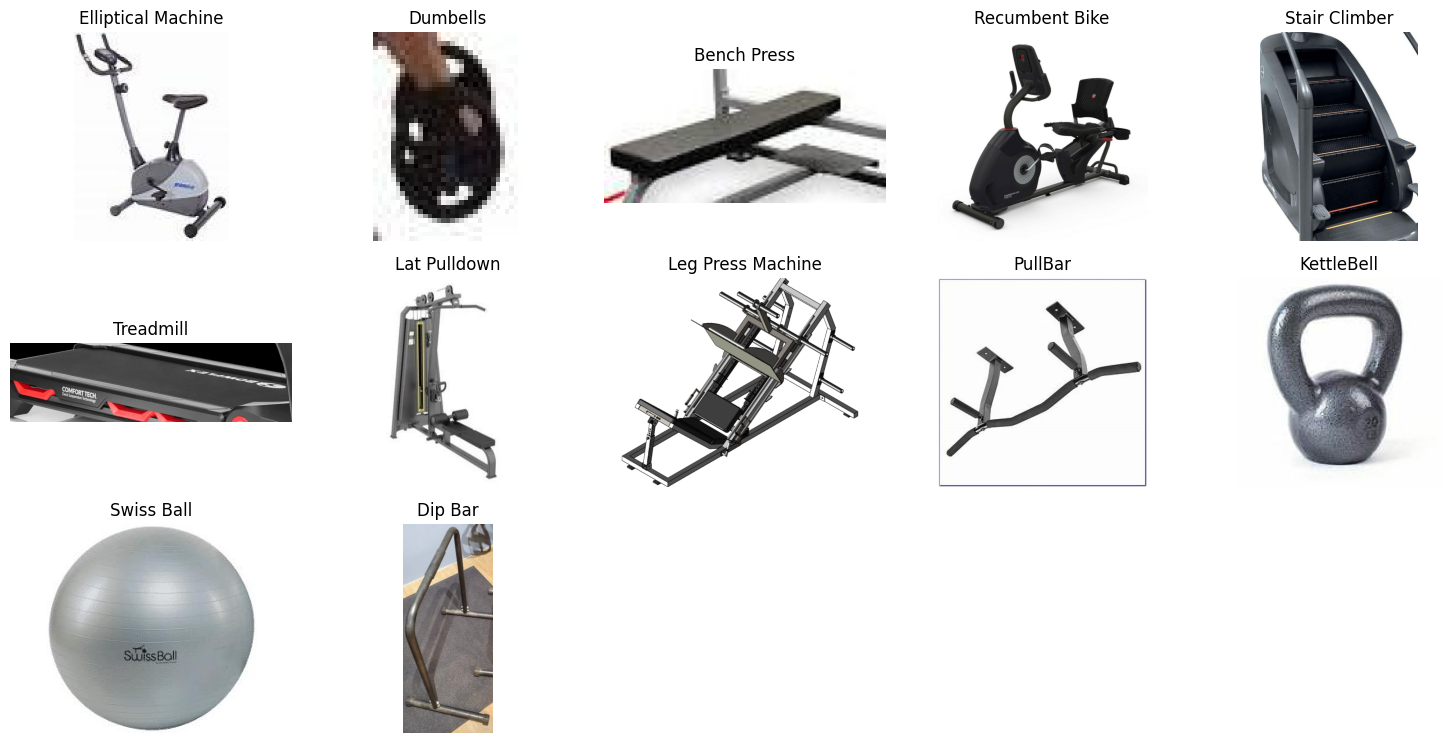

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_sample_images(data_dir, max_classes=19):
    """
    Display one sample image from each class in the dataset.
    """
    try:
        # Get list of class directories
        classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
        plt.figure(figsize=(15, 10))

        for i, cls in enumerate(classes[:max_classes]):
            cls_path = os.path.join(data_dir, cls)
            if os.path.isdir(cls_path):
                # Get list of image files in the class directory
                image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
                if image_files:
                    image_path = os.path.join(cls_path, image_files[0])

                    # Open the image using PIL
                    img = Image.open(image_path)

                    # Display the image
                    plt.subplot(4, 5, i + 1)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error displaying images: {e}")

# Display sample images
display_sample_images(DATASET_DIR)


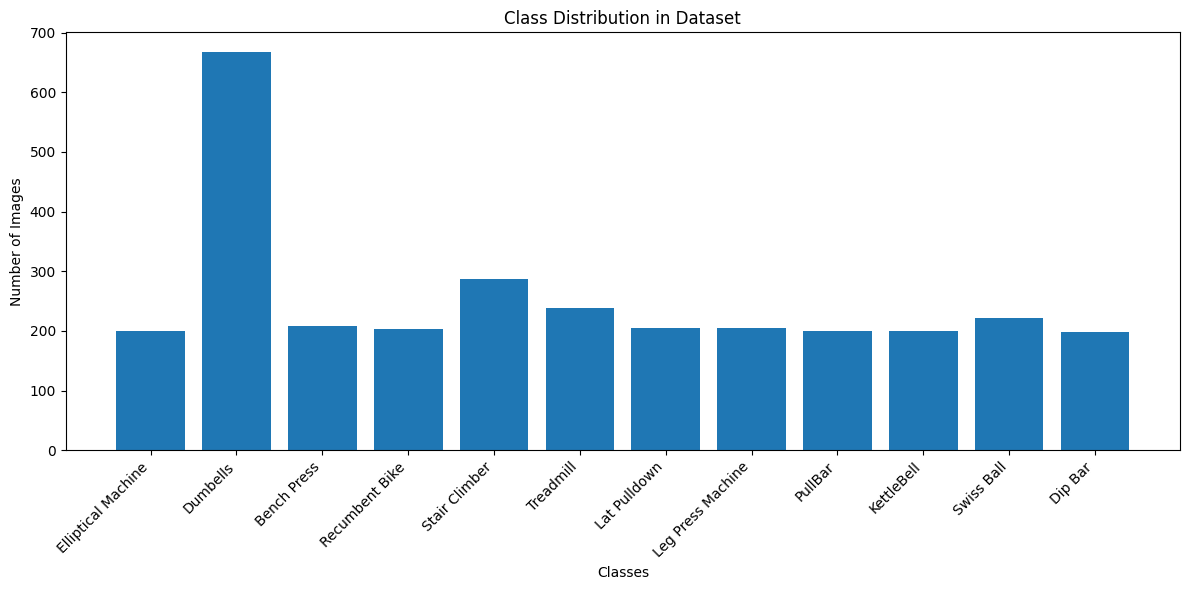

In [6]:
def plot_class_distribution(data_dir):
    """
    Plot the distribution of images across classes in the dataset.

    Parameters:
    - data_dir: Path to the dataset directory where each class has its own subdirectory.
    """
    try:
        # List all classes (subdirectories) in the dataset directory
        classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
        class_counts = []

        # Count the number of images in each class
        for cls in classes:
            cls_path = os.path.join(data_dir, cls)
            num_images = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
            class_counts.append(num_images)

        # Plot the distribution
        plt.figure(figsize=(12, 6))
        plt.bar(classes, class_counts, tick_label=classes)
        plt.xticks(rotation=45, ha='right')
        plt.title('Class Distribution in Dataset')
        plt.xlabel('Classes')
        plt.ylabel('Number of Images')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting class distribution: {e}")

# Plot class distribution
plot_class_distribution(DATASET_DIR)


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
DATASET_DIR = '/content/drive/MyDrive/C242-PS284/Gym Dataset Cropped'
# Parameters
batch_size = 128
image_size = (128, 128)
test_split = 0.1  # 10% test data

# Data Generators for training and validation
train_val_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10,
    validation_split=0.2  # 10% of remaining data for validation
)

train_generator = train_val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Data Generator for testing
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset=None,  # Test split handled manually
    shuffle=False  # Do not shuffle test data
)

# Manually split test data
total_samples = len(test_generator.filenames)
test_samples = int(total_samples * test_split)
test_generator.filenames = test_generator.filenames[:test_samples]
test_generator.samples = test_samples

# Print dataset statistics
print("Number of classes:", len(train_generator.class_indices))
print("Number of training images:", train_generator.n)
print("Number of validation images:", validation_generator.n)
print("Number of test images:", test_generator.samples)


Found 2432 images belonging to 12 classes.
Found 603 images belonging to 12 classes.
Found 3035 images belonging to 12 classes.
Number of classes: 12
Number of training images: 2432
Number of validation images: 603
Number of test images: 303


In [35]:
# Define the model using MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model to speed up training

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# EarlyStoppingCallback for accuracy >= 98%
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nStopping training as validation accuracy reached {val_acc:.2f} (≥ {self.target_accuracy:.2f})")
            self.model.stop_training = True

early_stopping = EarlyStoppingAtAccuracy(target_accuracy=0.999)

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dense_7 (Dense)             (None, 12)                6156      
                                                                 
Total params: 2920012 (11.14 MB)
Trainable params: 662

In [37]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
)

Epoch 1/10
19/19 [==============================] - 75s 4s/step - loss: 0.7618 - accuracy: 0.7825 - val_loss: 0.1906 - val_accuracy: 0.9320
Epoch 2/10
19/19 [==============================] - 69s 4s/step - loss: 0.1596 - accuracy: 0.9453 - val_loss: 0.1301 - val_accuracy: 0.9635
Epoch 3/10
19/19 [==============================] - 67s 4s/step - loss: 0.1058 - accuracy: 0.9630 - val_loss: 0.1375 - val_accuracy: 0.9652
Epoch 4/10
19/19 [==============================] - 68s 4s/step - loss: 0.0795 - accuracy: 0.9712 - val_loss: 0.1040 - val_accuracy: 0.9701
Epoch 5/10
19/19 [==============================] - 69s 4s/step - loss: 0.0557 - accuracy: 0.9827 - val_loss: 0.1222 - val_accuracy: 0.9685
Epoch 6/10
19/19 [==============================] - 68s 4s/step - loss: 0.0475 - accuracy: 0.9852 - val_loss: 0.0914 - val_accuracy: 0.9735
Epoch 7/10
19/19 [==============================] - 67s 4s/step - loss: 0.0340 - accuracy: 0.9901 - val_loss: 0.0977 - val_accuracy: 0.9735
Epoch 8/10
19/19 [==

In [38]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

5/5 [==============================] - 14s 3s/step - loss: 0.0705 - accuracy: 0.9751
Validation Loss: 0.07049872726202011
Validation Accuracy: 0.9751243591308594


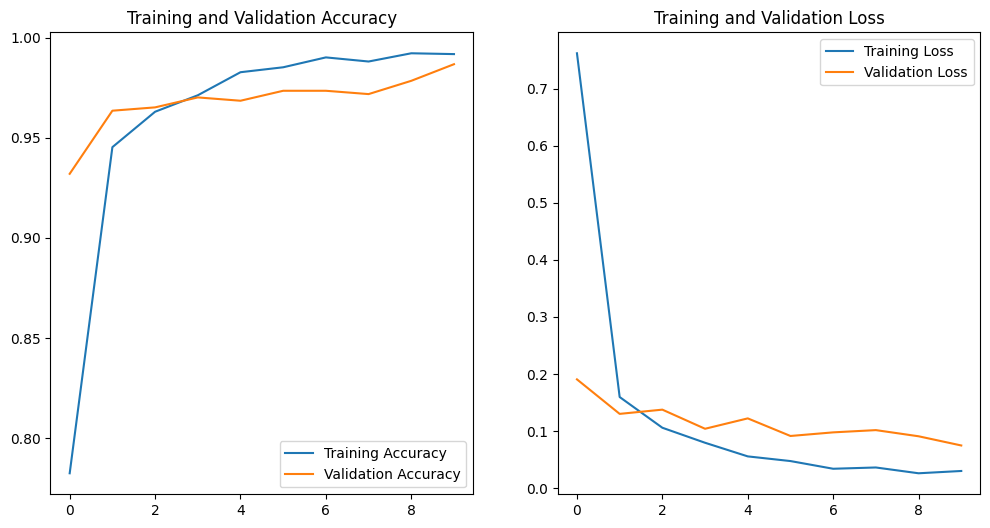

In [39]:
# Plot training history
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss over epochs.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

1/1 [==============================] - 0s 33ms/step


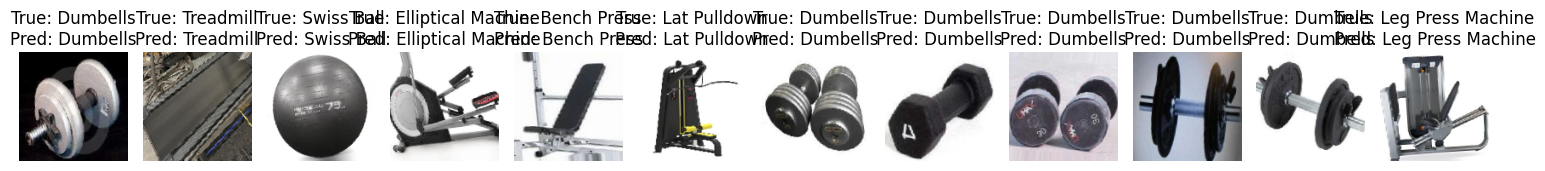

In [46]:
# Test with some validation images
def test_model_with_sample_images(validation_generator, model, num_samples=12):
    """
    Display predictions on sample validation images along with true labels.
    """
    # Get a batch of images and labels from the validation set
    images, labels = next(validation_generator)

    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = images[i]
        label = labels[i]

        # Predict the class of the image
        prediction = model.predict(img.reshape(1, *img.shape))
        predicted_label = list(validation_generator.class_indices.keys())[prediction.argmax()]
        true_label = list(validation_generator.class_indices.keys())[label.argmax()]

        # Display the image with the predicted and true labels
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on sample images
test_model_with_sample_images(validation_generator, model)

In [42]:
# Generate predictions and true labels from the test set
def evaluate_on_test_set(model, test_generator):
    """
    Generate predictions on the test set and display a confusion matrix.

    Parameters:
    - model: Trained Keras model.
    - test_generator: Data generator for the test set.

    Returns:
    - y_true: True labels.
    - y_pred: Predicted labels.
    """
    # Get predictions and true labels
    y_pred = []
    y_true = []

    for images, labels in test_generator:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels, axis=1))

        # Break when we've iterated over all samples
        if len(y_true) >= test_generator.n:
            break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
    disp.plot(xticks_rotation='vertical', cmap='viridis')

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

    return y_true, y_pred


Found 3035 images belonging to 12 classes.
3/3 [==============================] - 1s 443ms/step

Classification Report:
                    precision    recall  f1-score   support

       Bench Press       1.00      0.98      0.99       209
           Dip Bar       0.99      0.99      0.99       198
          Dumbells       1.00      1.00      1.00       667
Elliptical Machine       0.99      0.97      0.98       200
        KettleBell       1.00      1.00      1.00       200
      Lat Pulldown       0.99      1.00      0.99       205
 Leg Press Machine       0.99      1.00      0.99       205
           PullBar       0.99      0.99      0.99       200
    Recumbent Bike       0.98      0.99      0.98       203
     Stair Climber       0.99      1.00      0.99       287
        Swiss Ball       1.00      1.00      1.00       222
         Treadmill       0.99      0.99      0.99       239

          accuracy                           0.99      3035
         macro avg       0.99      0.9

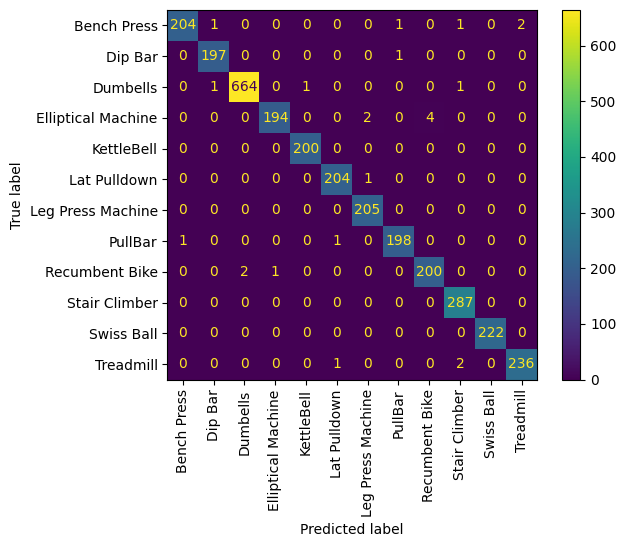

In [43]:
# Test Generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescaling
test_generator = test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Maintain order for accurate results
)

# Evaluate the model on the test set
y_true, y_pred = evaluate_on_test_set(model, test_generator)

In [47]:
def upload_and_test(model, target_size, class_indices):
    """
    Upload file, preprocess, and predict using the trained model.

    Parameters:
    - model: Trained Keras model.
    - target_size: Tuple (width, height) for resizing the input image.
    - class_indices: Dictionary of class labels and indices.

    Returns:
    None
    """
    # Upload file widget
    uploader = FileUpload(accept='image/*', multiple=False)
    display(uploader)

    def on_upload(change):
        # Load and preprocess the uploaded image
        for name, file_info in uploader.value.items():
            img = Image.open(io.BytesIO(file_info['content'])) # 'io' is now defined
            img = img.resize(target_size)  # Resize image to match model input size
            img_array = img_to_array(img) / 255.0  # Normalize image data
            img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for model input

            # Predict
            prediction = model.predict(img_array)
            predicted_label = list(class_indices.keys())[np.argmax(prediction)]
            confidence = np.max(prediction)

            # Show the uploaded image and prediction
            plt.imshow(img)
            plt.title(f"Prediction: {predicted_label} ({confidence*100:.2f}%)")
            plt.axis('off')
            plt.show()

    uploader.observe(on_upload, names='value')

FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 1s 743ms/step


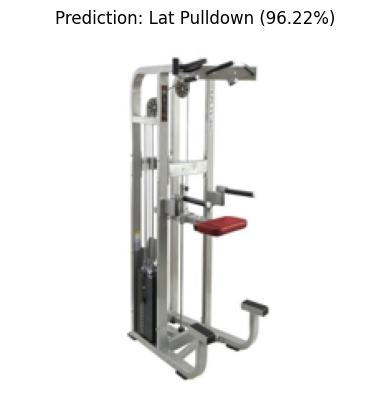

1/1 [==============================] - 0s 51ms/step


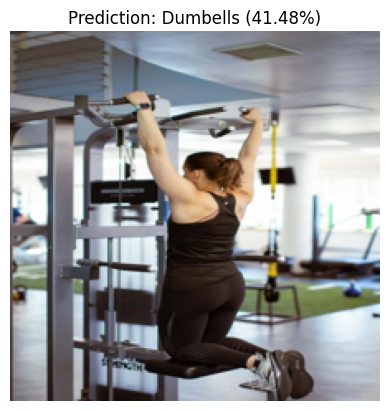

1/1 [==============================] - 0s 50ms/step


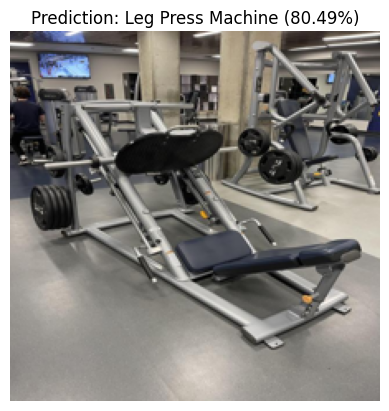

1/1 [==============================] - 0s 50ms/step


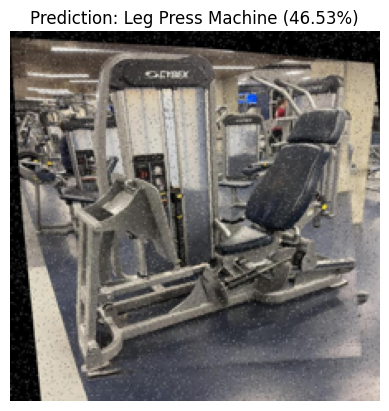

In [48]:
upload_and_test(model, target_size=(224, 224), class_indices=validation_generator.class_indices)


In [50]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/C242-PS284/saved_model/gym_model_MobileNetV2_kayaknyafixx.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/C242-PS284/saved_model/gym_model_MobileNetV2_kayaknyafixx.h5
